# Classification Between Group3 and Group4

## Required Imports

In [264]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier

## Data Preprocessing/Loading 

In [265]:
# load data
file_path = "features.csv"
df = pd.read_csv(file_path)
df = df[df['molecular'].isin(['group3', 'group4'])]
df.head()

,住院号,case,molecular,sex,age,split,t1_diagnostics_Versions_PyRadiomics,t1_diagnostics_Versions_Numpy,t1_diagnostics_Versions_SimpleITK,t1_diagnostics_Versions_PyWavelet,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,523990,523990jiangjunliang,group4,M,5.0,test,v3.0.1,1.24.0,2.2.0,1.4.1,...,0.139828,0.002692,2146.381813,0.289582,0.553560,545.320313,0.001513,7.970995,0.274153,65.452446
2,573499,573499wangyichen,group4,F,7.0,test,v3.0.1,1.24.0,2.2.0,1.4.1,...,0.038659,0.000883,3603.669974,0.350517,0.612712,1295.164923,0.000567,7.896832,0.351728,38.601686
3,420087,420087chenxuanyu,group4,M,5.0,test,v3.0.1,1.24.0,2.2.0,1.4.1,...,0.010905,0.000603,5775.595510,0.379125,0.638758,1786.470304,0.000364,7.783485,0.411641,15.026543
4,450251,450251zhenbaoshu,group4,M,7.0,test,v3.0.1,1.24.0,2.2.0,1.4.1,...,0.071403,0.001039,3404.884640,0.312232,0.576097,1158.195974,0.000580,8.251352,0.290994,76.299521
6,439720,439720zhangchujun,group4,M,11.0,test,v3.0.1,1.24.0,2.2.0,1.4.1,...,0.011199,0.001845,1845.632400,0.449606,0.697038,1134.987979,0.001195,7.483380,0.506290,6.059310


In [266]:
# obtain list of features selected from LASSO
# reduced_feats_path = "/Users/samwwong/Desktop/Michael Zhang/reduced_molec.xlsx"
# reduced_features = pd.read_excel(reduced_feats_path)
# reduced_features_list = reduced_features.loc[reduced_features['type3_type4'].isnull() == False,
#                                              ['type3_type4']].values.tolist()
# reduced_features_list = [item for sublist in reduced_features_list for item in sublist]
df['age'] = df['age'].map(lambda x: 0 if pd.isna(x) else x)
reduced_features_list = ['age', 't1_log-sigma-5-mm-3D_glcm_MaximumProbability', 't1_wavelet-HHL_firstorder_Median', 't1_wavelet-HLL_firstorder_Mean', 't1_wavelet-HLL_glrlm_RunLengthNonUniformity', 't1_wavelet-LHH_glcm_Idmn', 't1_wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis', 't1_wavelet-LLH_firstorder_Median', 't1_wavelet-LLH_glszm_LowGrayLevelZoneEmphasis', 't2_log-sigma-1-mm-3D_firstorder_Median', 't2_wavelet-HHH_firstorder_Mean', 't1_log-sigma-3-mm-3D_firstorder_Median', 't2_original_glcm_Imc1', 't2_original_shape_Elongation', 't2_wavelet-HHL_firstorder_InterquartileRange', 't2_wavelet-HLH_glszm_GrayLevelNonUniformity']
features_after_lasso = df[reduced_features_list]
print(features_after_lasso.head())

    age  t1_log-sigma-5-mm-3D_glcm_MaximumProbability  \
0   5.0                                      0.166533   
2   7.0                                      0.207919   
3   5.0                                      0.121404   
4   7.0                                      0.224192   
6  11.0                                      0.128623   

   t1_wavelet-HHL_firstorder_Median  t1_wavelet-HLL_firstorder_Mean  \
0                          0.002275                        0.073425   
2                         -0.000474                        0.112839   
3                          0.004284                        0.262881   
4                         -0.003064                        0.036828   
6                          0.005444                        0.188688   

   t1_wavelet-HLL_glrlm_RunLengthNonUniformity  t1_wavelet-LHH_glcm_Idmn  \
0                                  3340.656899                  0.985080   
2                                  4135.679899                  0.990623   
3 

In [267]:
# Binarizing target
target = df["molecular"]

# Marking 0 as type3 and 1 type4
mapping_dict = {0: 'group3', 1: 'group4'}
target = target.map(dict(group3 = 0, group4 = 1))
print(target)
print(target.value_counts())

0      1
2      1
3      1
4      1
6      1
      ..
226    1
232    1
237    1
242    1
243    1
Name: molecular, Length: 144, dtype: int64
1    104
0     40
Name: molecular, dtype: int64


In [268]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target,
#                                                     test_size = 0.25, random_state = 42)

train_idx = df['split'].isin(map(str, range(5)))
test_idx = df['split'] == 'test'

X_train = features_after_lasso[train_idx]
X_test = features_after_lasso[test_idx]
y_train = target[train_idx]
y_test = target[test_idx]

print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

TRAIN
1    50
0    27
Name: molecular, dtype: int64
TEST
1    26
0    13
Name: molecular, dtype: int64


### Resampling to Correct for Imbalance

In [269]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0]
X_1 = X[X['molecular'] == 1]

In [270]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [271]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]
print(y_train.value_counts())

1    50
0    50
Name: molecular, dtype: int64


### Standardizing Features

In [272]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [273]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [274]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

## Modeling

### User Defined Functions for Metrics

In [275]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.4f} - {:0.4}]".format(name, 
    confidence_lower, confidence_upper))

In [276]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TN / (TN + FP)

In [277]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [278]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN)        

In [279]:
def print_metrics(y_test, y_pred):
    print("Sens Score: " + str.format('{0:.4f}', (recall_score(y_test, y_pred))))
    print("Spec Score: " + str.format('{0:.4f}', (specificity_score(y_test.to_numpy(), y_pred))))
    print("PPV Score: " + str.format('{0:.4f}', (positive_pv_score(y_test.to_numpy(), y_pred))))
    print("NPV Score: " + str.format('{0:.4f}', (negative_pv_score(y_test.to_numpy(), y_pred))))
    print(f"Acc Score: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")

In [280]:
def plot_roc_curve(model_name):
    sns.set()
    plt.figure(figsize=(7, 7))

    ns_preds = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

    plt.legend(loc='lower right')
    plt.title(f'{model_name}: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    short_auc = round(auc,4)
    plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
    plt.show()

In [281]:
def create_confusion_matrix(model_name, model, X, y):
    matrix = ConfusionMatrixDisplay.from_estimator(model, X, y,
                               cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show(matrix)
    plt.show()

### User Defined Functions for Modeling

In [282]:
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

### SVM

#### Grid Search for Hyperparameters

In [283]:
svm_model = svm.SVC()
svm_grid_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

grid_search(svm_model, svm_grid_params, X_train, y_train)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


#### Model Performance

In [284]:
svm_model = svm.SVC(C = 1, gamma = 0.01, kernel = 'rbf', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(y_test)


0     1
2     1
3     1
4     1
6     1
7     1
8     0
9     1
10    1
13    1
14    0
15    1
16    1
18    0
20    1
21    0
22    0
25    1
27    1
29    1
30    0
31    1
32    1
34    0
35    1
36    0
37    1
38    1
39    0
40    1
41    1
42    1
43    1
44    0
45    0
46    0
48    1
49    0
52    1
Name: molecular, dtype: int64


In [285]:
print_metrics(y_test, y_pred)

Sens Score: 0.6154
Spec Score: 0.4615
PPV Score: 0.6957
NPV Score: 0.3750
Acc Score: 0.5641025641025641
F1 Score: 0.6530612244897959


In [286]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.5710


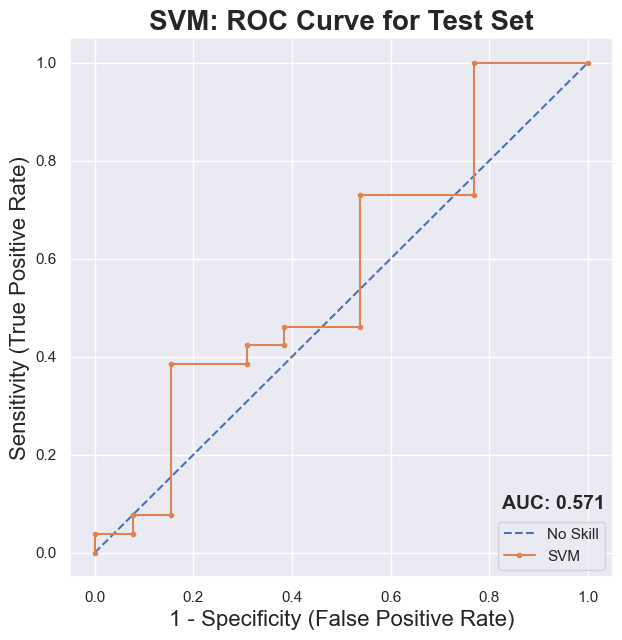

In [287]:
plot_roc_curve('SVM')

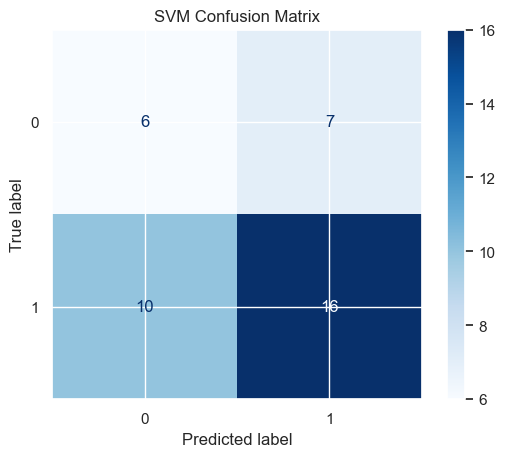

In [288]:
create_confusion_matrix('SVM', svm_model, X_test, y_test)

### Logistic Regression

#### Grid Search for Hyperparameters

In [289]:
lr_model = LogisticRegression()
lr_grid_params = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

grid_search(lr_model, lr_grid_params, X_train, y_train)

/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/luolx21/miniconda3/

{'C': 10, 'penalty': None}


/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


### Model Performance

In [290]:
lr_model = LogisticRegression(penalty = 'l2', C = 1)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [291]:
print_metrics(y_test, y_pred)

Sens Score: 0.6923
Spec Score: 0.3846
PPV Score: 0.6923
NPV Score: 0.3846
Acc Score: 0.5897435897435898
F1 Score: 0.6923076923076923


In [292]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.5473


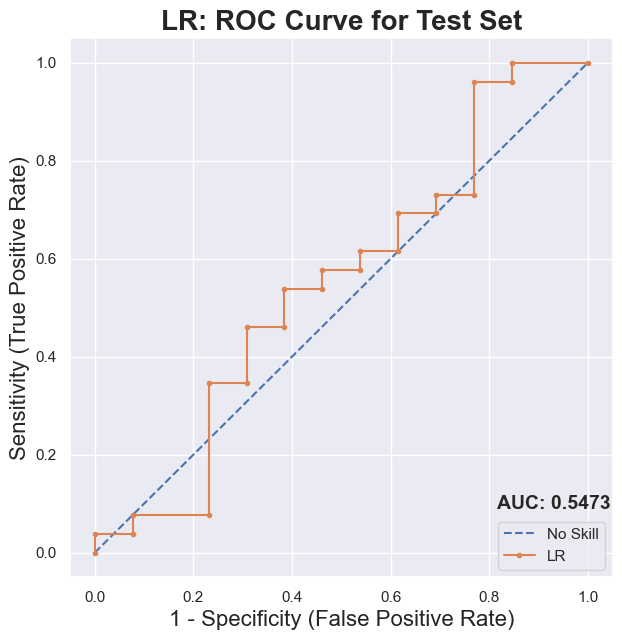

In [293]:
plot_roc_curve('LR')

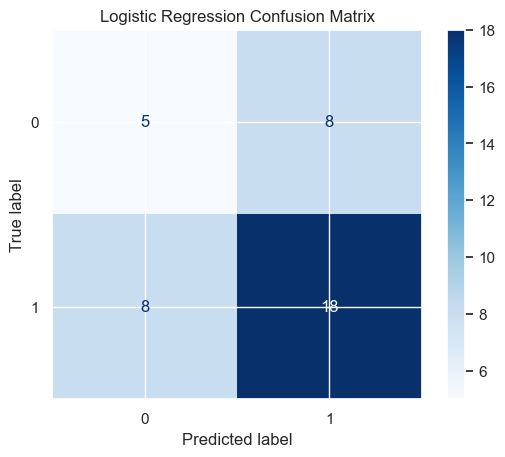

In [294]:
create_confusion_matrix('Logistic Regression', lr_model, X_test, y_test)

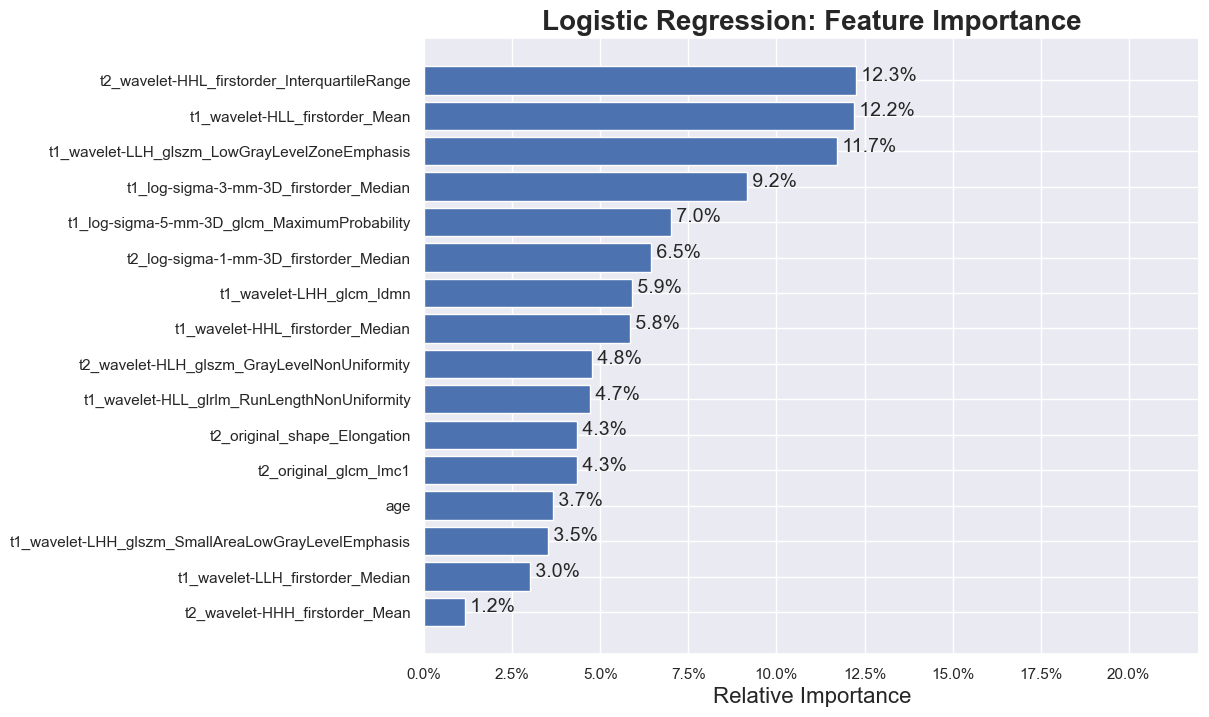

In [295]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.22)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

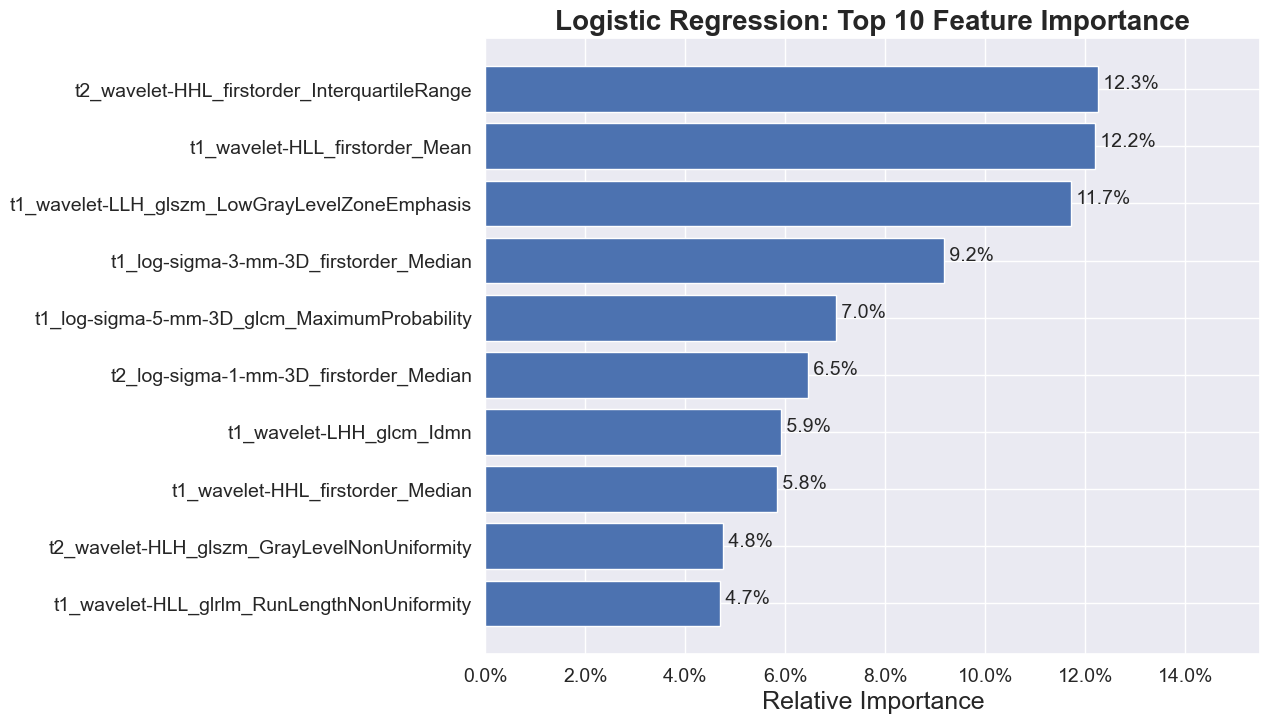

In [296]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Top 10 Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='b', align='center')
plt.xlim(0, 0.155)
for index, value in enumerate(importances[indices[-10:]]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)

plt.yticks(range(len(indices[-10:])), [feature_names[i] for i in indices[-10:]], fontsize=14)

plt.xlabel('Relative Importance',fontsize=18)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(fontsize=14)

plt.show()

Feature: 0, Score: 0.03012
Feature: 1, Score: -0.03513
Feature: 2, Score: 0.03669
Feature: 3, Score: 0.04328
Feature: 4, Score: 0.04341
Feature: 5, Score: 0.04698
Feature: 6, Score: 0.04754
Feature: 7, Score: -0.05839
Feature: 8, Score: -0.05904
Feature: 9, Score: -0.06451
Feature: 10, Score: 0.07010
Feature: 11, Score: -0.09167
Feature: 12, Score: -0.11719
Feature: 13, Score: 0.12193
Feature: 14, Score: -0.12251


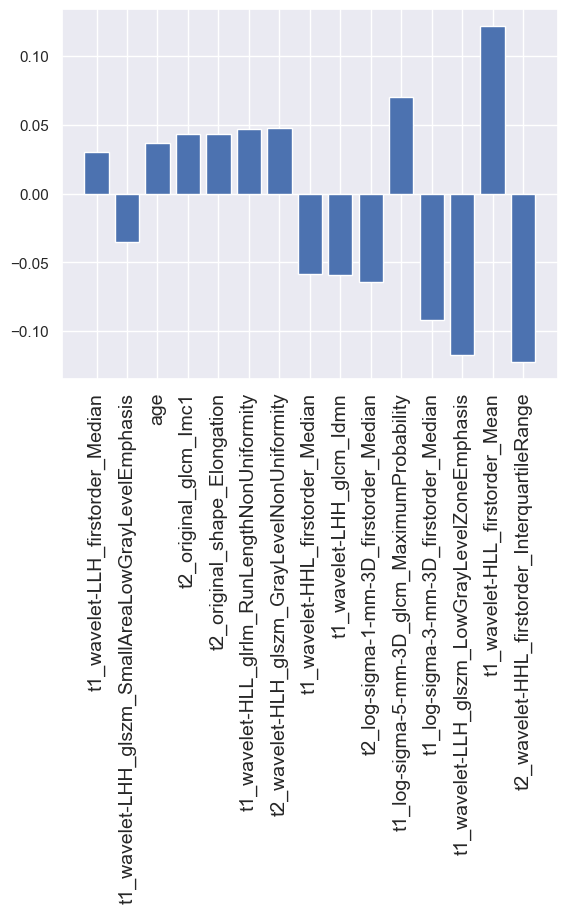

In [297]:
feature_names = X_test.columns.to_list()

importances_2 = lr_model.coef_[0]
importances_2 = (importances_2) / np.sum(np.abs(importances_2))

# summarize feature importance
for i,v in enumerate(importances_2[indices[-15:]]):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(indices[-15:]))], importances_2[indices[-15:]])
plt.xticks(range(len(indices[-15:])), [feature_names[i] for i in indices[-15:]], fontsize=14, rotation = 90)


plt.show()

### KNN

#### Grid Search for Hyperparameters

In [298]:
knn_model = KNeighborsClassifier()
knn_grid_params = {'n_neighbors': [3, 5, 7, 9]
}

grid_search(knn_model, knn_grid_params, X_train, y_train)

{'n_neighbors': 3}


#### Model Performance

In [299]:
knn_model = KNeighborsClassifier(n_neighbors = 7)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [300]:
print_metrics(y_test, y_pred)

Sens Score: 0.6923
Spec Score: 0.1538
PPV Score: 0.6207
NPV Score: 0.2000
Acc Score: 0.5128205128205128
F1 Score: 0.6545454545454545


In [301]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.5562


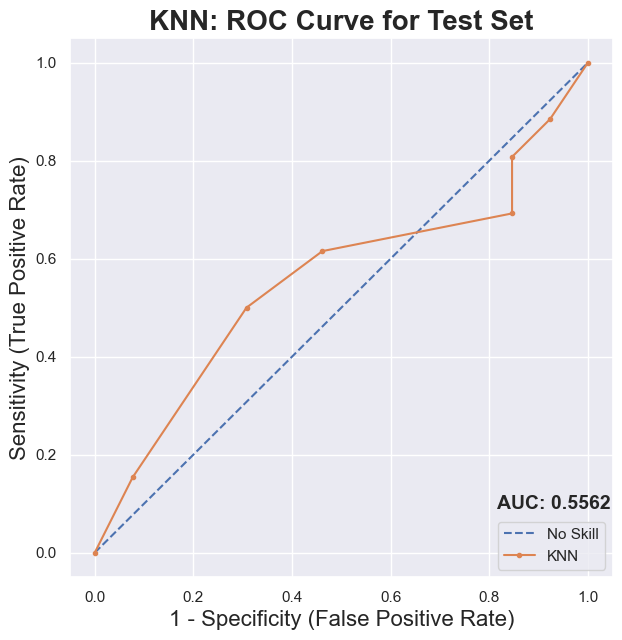

In [302]:
plot_roc_curve('KNN')

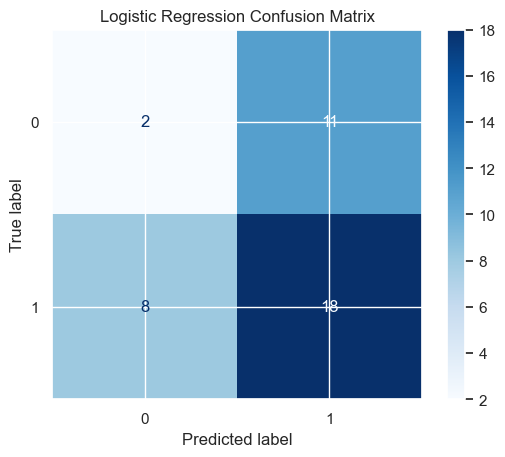

In [303]:
create_confusion_matrix('Logistic Regression', knn_model, X_test, y_test)

### Random Forest

#### Grid Search for Hyperparameters

In [304]:
rf_model = RandomForestClassifier(random_state = 42)
rf_grid_params = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

grid_search(rf_model, rf_grid_params, X_train, y_train)

{'max_depth': 4, 'n_estimators': 100}


/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 341, in fit
    self._validate_params()
  File "/home/luolx21/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/base.py", line 570, in _validate_params
    vali

#### Model Performance

In [305]:
rf_model = RandomForestClassifier(max_depth = 3, n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [306]:
print_metrics(y_test, y_pred)

Sens Score: 0.7308
Spec Score: 0.2308
PPV Score: 0.6552
NPV Score: 0.3000
Acc Score: 0.5641025641025641
F1 Score: 0.6909090909090909


In [307]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.5888


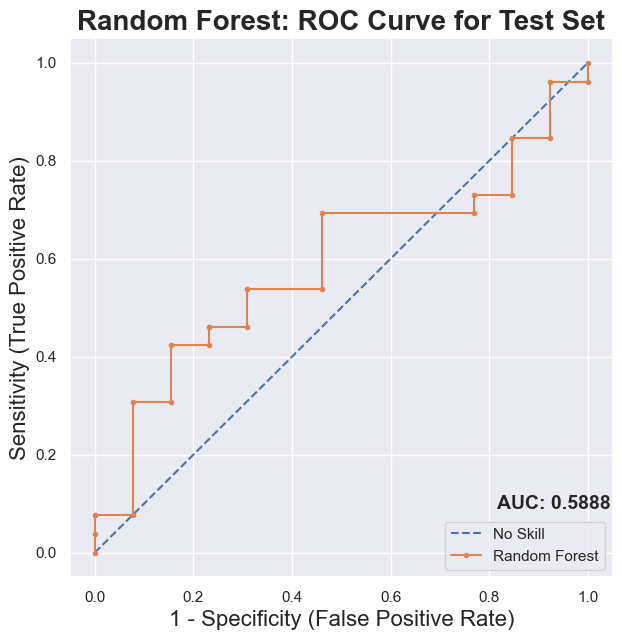

In [308]:
plot_roc_curve('Random Forest')

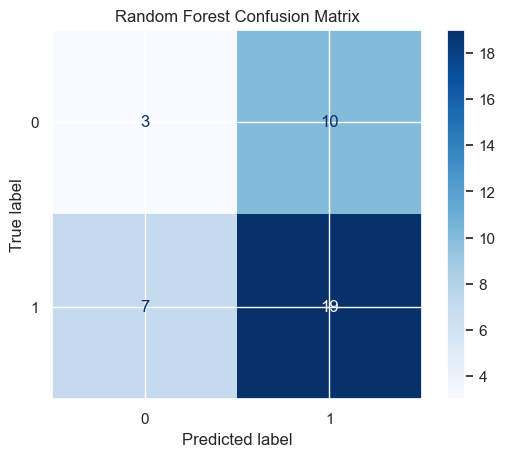

In [309]:
create_confusion_matrix('Random Forest', rf_model, X_test, y_test)

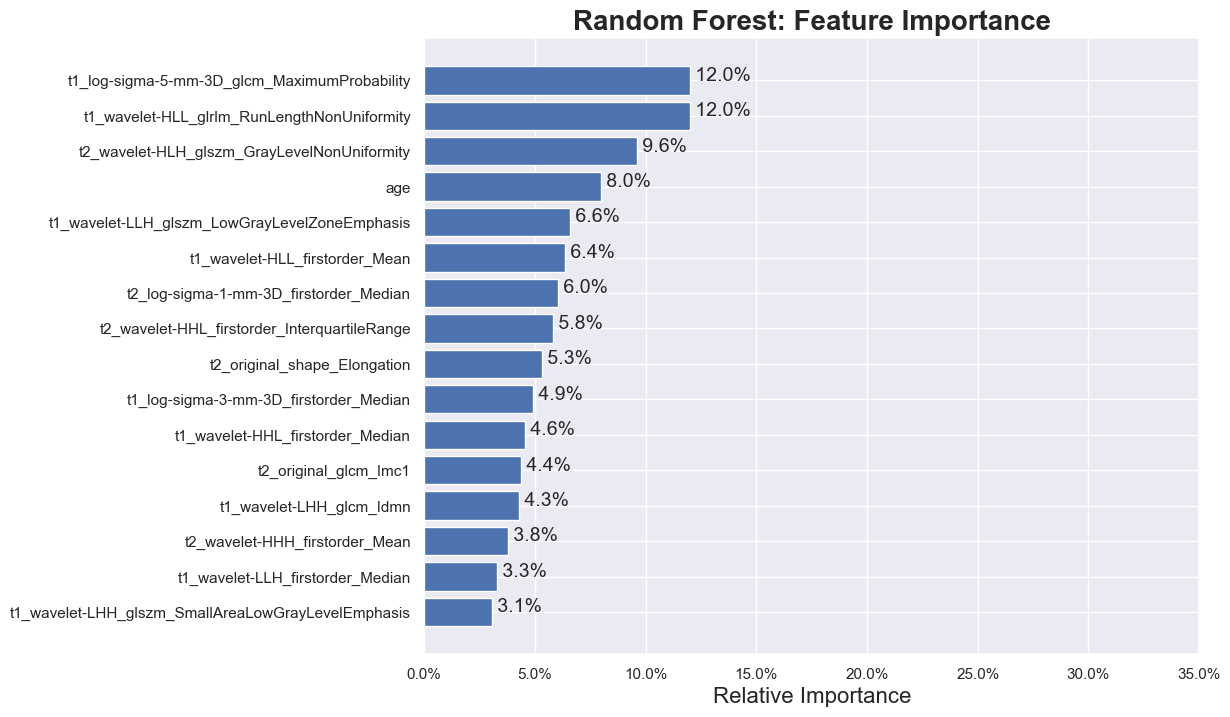

In [310]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Random Forest: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.35)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### XGBoost

#### Grid Search for Hyperparameters

In [311]:
xgb_model = XGBClassifier(random_state = 42)
xgb_grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

grid_search(xgb_model, xgb_grid_params, X_train, y_train)

{'learning_rate': 0.5, 'max_depth': 4}


#### Model Performance

In [312]:
xgb_model = XGBClassifier(learning_rate = 0.3, max_depth = 4, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [313]:
print_metrics(y_test, y_pred)

Sens Score: 0.8462
Spec Score: 0.3077
PPV Score: 0.7097
NPV Score: 0.5000
Acc Score: 0.6666666666666666
F1 Score: 0.7719298245614036


In [314]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print(f"AUC: {auc}")

AUC: 0.6272189349112425


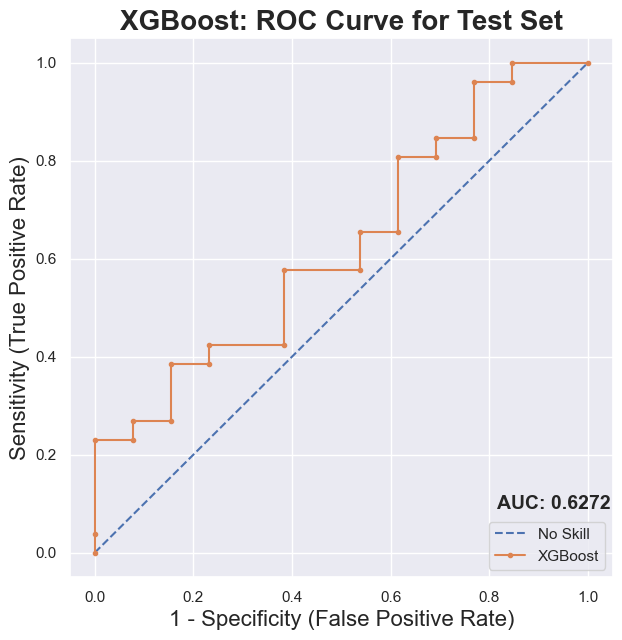

In [315]:
plot_roc_curve('XGBoost')

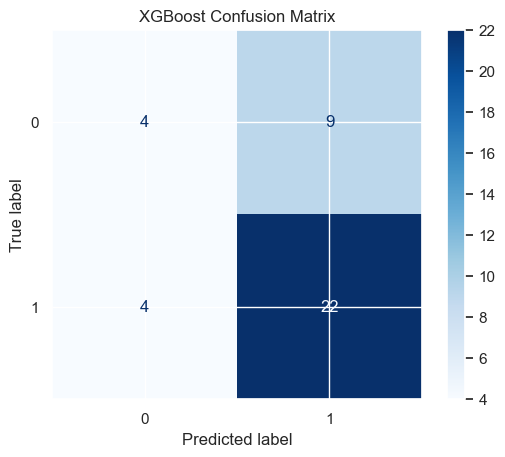

In [316]:
create_confusion_matrix('XGBoost', xgb_model, X_test, y_test)

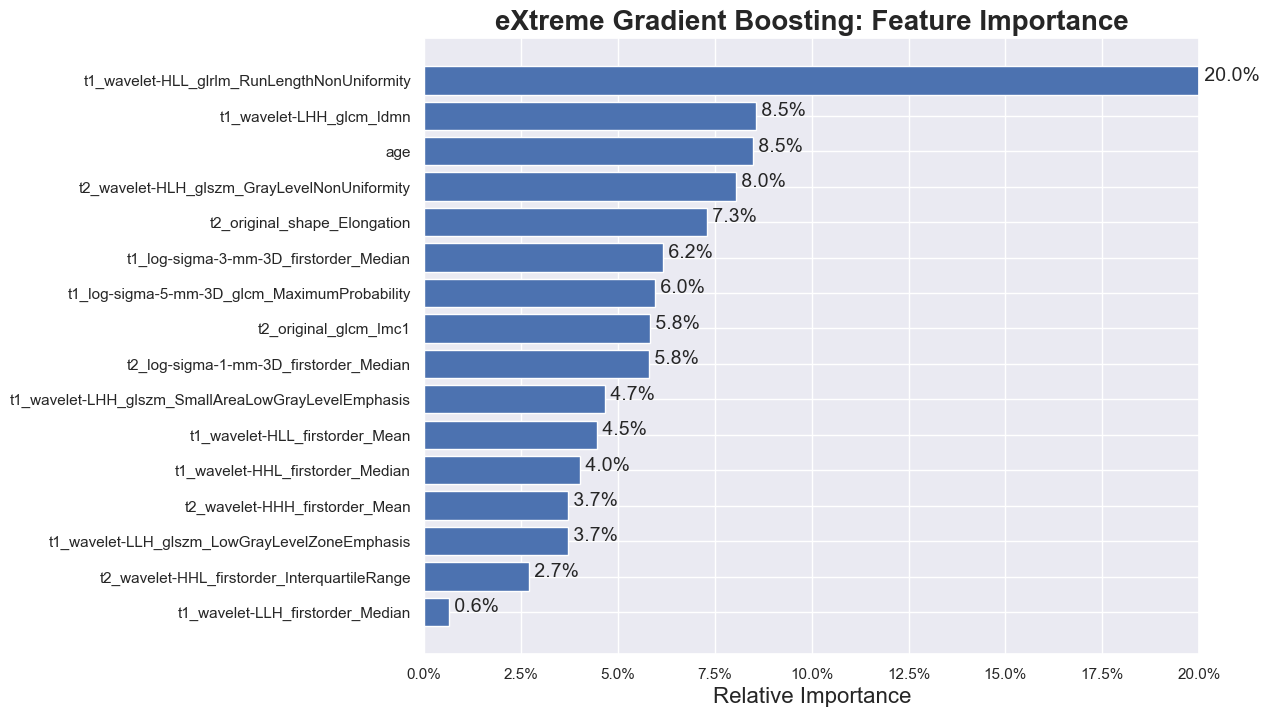

In [317]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('eXtreme Gradient Boosting: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.20)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### Neural Net

#### Grid Search for Hyperparameters

In [318]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
nn_grid_params = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search(nn_model, nn_grid_params, X_train, y_train)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


#### Model Performance

In [319]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [320]:
print_metrics(y_test, y_pred)

Sens Score: 0.7308
Spec Score: 0.3846
PPV Score: 0.7037
NPV Score: 0.4167
Acc Score: 0.6153846153846154
F1 Score: 0.7169811320754716


In [324]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print(f"AUC: {auc}")

AUC: 0.5650887573964496


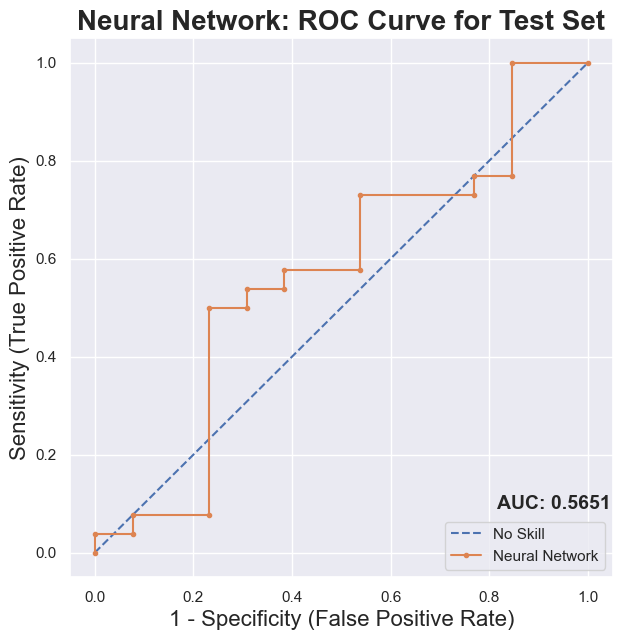

In [322]:
plot_roc_curve('Neural Network')

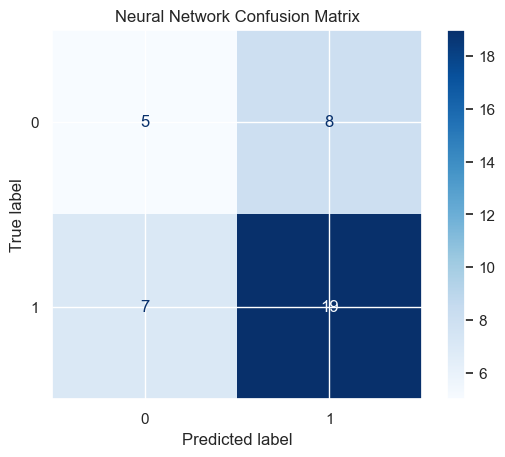

In [323]:
create_confusion_matrix('Neural Network', nn_model, X_test, y_test)